# Task 2b: Sign Detection with YOLOv11

**Student:** Luigi Camilleri
**Student ID:** 0312805L    
**Model:** YOLOv11


This notebook implements a YOLOv11 object detector to detect Maltese traffic signs. It covers:
1.  **Dataset Preparation**: Setting up the data.yaml configuration and specifying its path
2.  **Model Training**: Fine-tuning a pre-trained `YOLOv11` model.
3.  **Evaluation**: Evaluating the best-performing YOLOv11 model on the test set.
4.  **Inference & Analytics**: Visualising evaluation curves and comparing ground-truth labels with model predictions.

In [ ]:
import importlib
import subprocess
import sys
import os
import glob
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter notebooks
%matplotlib inline


#  Package bootstrap helper
def ensure_package(pkg: str, import_name: str | None = None, pip_name: str | None = None):
    try:
        return importlib.import_module(import_name or pkg)
    except ImportError:
        pip_target = pip_name or pkg
        print(f"Installing missing package: {pip_target}")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pip_target],
            stdout=subprocess.DEVNULL
        )
        return importlib.import_module(import_name or pkg)

# Ensures third-party packages
torch = ensure_package("torch")
ultralytics = ensure_package("ultralytics")

#  Used for reproducibility in torch operations
torch.manual_seed(42)

print("Environment ready: all dependencies installed and imported.")

Environment ready: all dependencies installed and imported.


## 1. Dataset Preparation

The dataset for the YOLOv11 model is prepared automatically by the data.yaml file in the YOLO_COCO dataset

In [5]:
# Path to the data.yaml file
DATA_YAML = 'Assignment Material/YOLO_COCO_view_angle/data.yaml'

## 2. Model Training

In [ ]:
from ultralytics import YOLO

# Loads a pre-trained YOLOv11 model
model = YOLO('yolo11m.pt')
# Trains the model and gets the training results
results = model.train(
    data=DATA_YAML,
    epochs=100,
    imgsz=640,
    batch=8,
    project='models',
    name='yolov11_view_angle',
    exist_ok=True
)


Ultralytics 8.4.3 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Assignment Material/YOLO_COCO_view_angle/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov11_view_angle, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

## 3. Evaluating on Test Set

This section loads the best fine tuned YOLOv11 model and evaluates its performance on the test set, generating metrics and plots to assess detection accuracy.

In [11]:
# Evaluates the best trained model on the test set and generate plots
best_model = YOLO('models/yolov11_view_angle/weights/best.pt')
test_results = best_model.val(
    data=DATA_YAML,
    project="runs", # The parent directory name
    name="yolov11_view_angle",
    split="test",    # explicitly uses the test set
    plots=True       # generates plots like confusion matrix, PR curves
)

Ultralytics 8.4.3 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 126 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2844.3±395.0 MB/s, size: 2480.0 KB)
val: Scanning /content/Assignment Material/YOLO_COCO_view_angle/labels/test.cache... 116 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 116/116 34.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.2s/it 9.6s
                   all        116        130      0.876      0.839      0.872      0.724
                  Back         46         49      0.862      0.918      0.925       0.83
                 Front         33         36       0.88      0.889        0.9      0.805
                  Side         43         45      0.885      0.711      0.793      0.536
Speed: 2.9ms preprocess, 18.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /co

## 4. Analytics & Visualization

This section provides functions and tools to visualize the results and analytics of the YOLOv11 model, including displaying images and evaluation plots.

In [ ]:
# Directory containing YOLOv11's best model's outputs
val_dir = 'runs/yolov11_view_angle'

# Function which displays images from a folder in a grid format
def show_images_from_folder(
    folder,
    title,
    patterns,
    cols = 2,
    img_size=5
):

    image_paths = []
    for pattern in patterns:
        image_paths.extend(glob.glob(os.path.join(folder, pattern)))
    image_paths.sort()

    if not image_paths:
        print(f'No images found in {folder}')
        return

    n = len(image_paths)
    rows = (n + cols - 1) // cols # Logic used to get number of rows needed

    # Figure size scaling with rows
    fig_width = cols * img_size
    fig_height = rows * img_size

    # Creates subplots
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(fig_width, fig_height),
        constrained_layout=True
    )

    # Flattens axes array for easy iteration
    axes = axes.flatten()

    for ax, img_path in zip(axes, image_paths):
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_aspect('equal')
        ax.axis('off')

    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close(fig)


### Evaluation Plots

Displays key evaluation plots such as the confusion matrix, precision-recall curves and F1-curves to help interpret the model's performance.

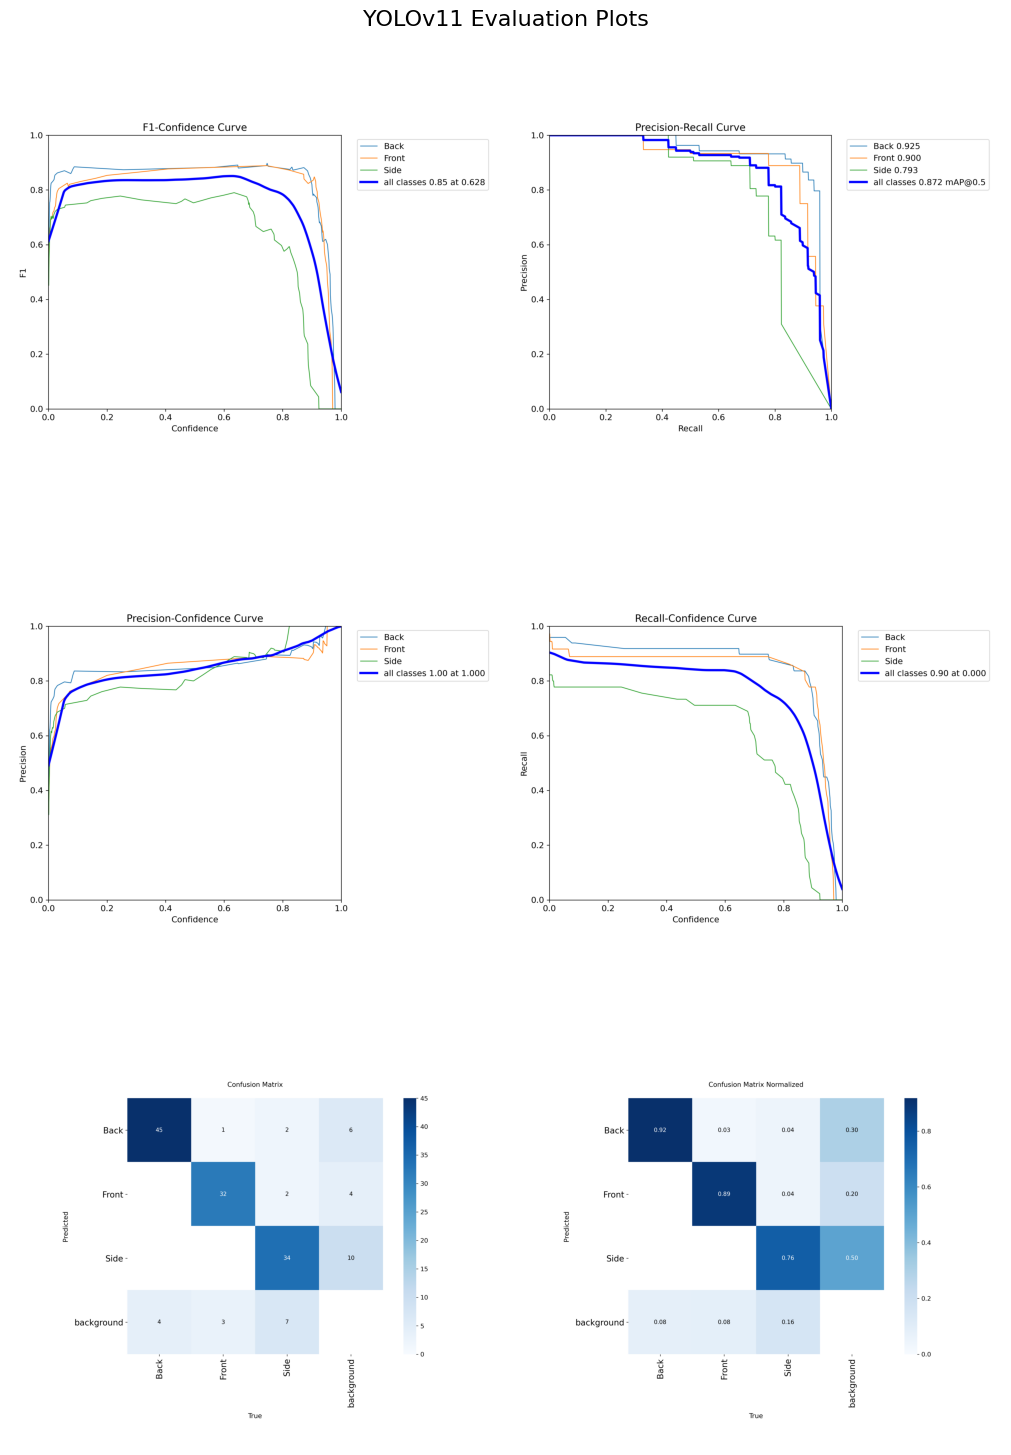

In [9]:
plot_patterns = (
    'confusion_matrix*.png',
    '*curve*.png',
)

show_images_from_folder(
    val_dir,
    title='YOLOv11 Evaluation Plots',
    patterns=plot_patterns
)



### Labels and Predictions

Shows sample images with predicted bounding boxes and labels, allowing for a visual comparison between model predictions and ground truth.

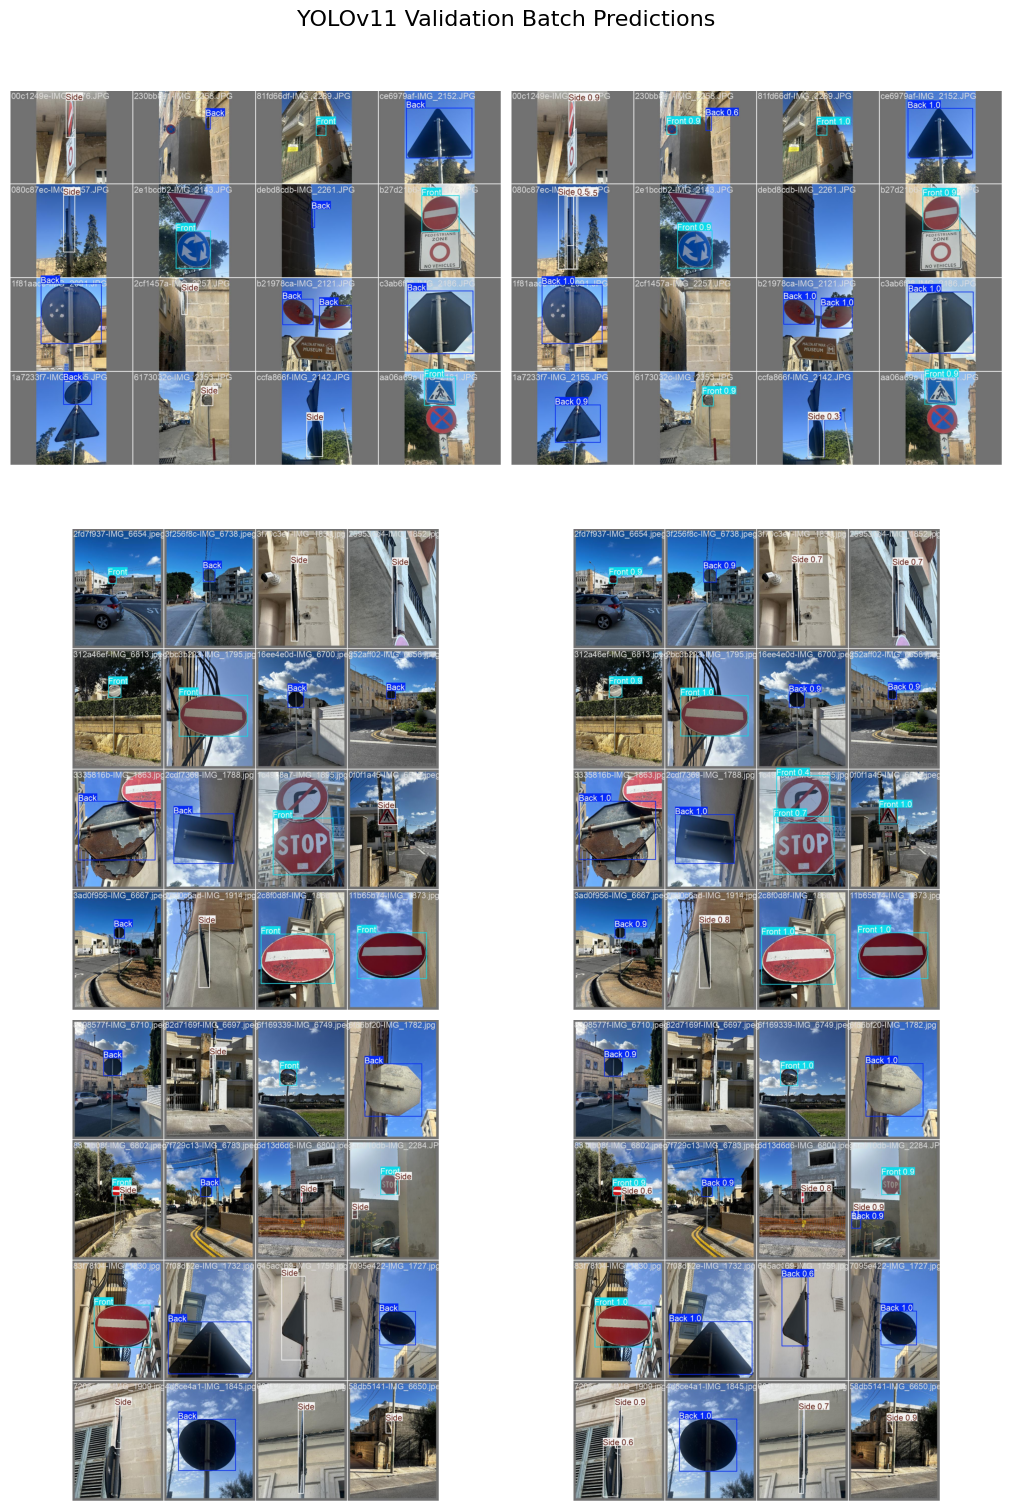

In [10]:
val_batch_patterns = ('val_batch*.jpg', 'val_batch*.png')

show_images_from_folder(
    val_dir,
    title='YOLOv11 Validation Batch Predictions',
    patterns=val_batch_patterns
)
